<a href="https://colab.research.google.com/github/attackgnome/pytorch_project/blob/master/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project to classify images using pytorch

The goal of this project is to gain familiarity with using pytorch for image classification and using gpu acceleration.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Make sure to change runtime options to allow use of gpu acceleration. 

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #check if gpu is enabled

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The output of torchvision datasets are PILImage images of range [0, 1]. Transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Display training images to get an idea of what is in the dataset and print their labels.

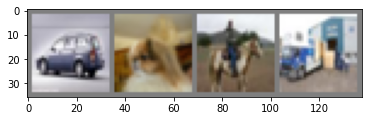

  car   dog horse truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now let's jump into defining the convolutional neural network. 

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.drop_layer = nn.Dropout(p=0.5)  ## Add dropout later to experiment
        self.fc2 = nn.Linear(120, 84)
        self.drop_layer = nn.Dropout(p=0.5)  ## Add dropout later to experiment
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Define the optimizer. Since we have multiple classes we will use cross-entropy loss and SGD with momentum since that is what the tutorial suggests.

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.ASGD(net.parameters(), lr=0.001, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0.0001) # try a different optimizer

Alright, lets go ahead and train the model. We will set a few parameters in the front end that differentiate it from the example in the tutorial. Specifically we will define the number of epochs we want to use in training to see if we can improve on the results from the tutorial. 

In [38]:
epoch_choice = 16 #number of epochs to select for training. 

for epoch in range(epoch_choice):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        if torch.cuda.is_available():
          inputs, labels = inputs.cuda(), labels.cuda() # Send input tensors to gpu if available.

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.805
[1,  4000] loss: 0.818
[1,  6000] loss: 0.816
[1,  8000] loss: 0.849
[1, 10000] loss: 0.844
[1, 12000] loss: 0.855
[2,  2000] loss: 0.758
[2,  4000] loss: 0.780
[2,  6000] loss: 0.807
[2,  8000] loss: 0.823
[2, 10000] loss: 0.842
[2, 12000] loss: 0.830
[3,  2000] loss: 0.742
[3,  4000] loss: 0.768
[3,  6000] loss: 0.802
[3,  8000] loss: 0.808
[3, 10000] loss: 0.795
[3, 12000] loss: 0.818
[4,  2000] loss: 0.694
[4,  4000] loss: 0.764
[4,  6000] loss: 0.765
[4,  8000] loss: 0.782
[4, 10000] loss: 0.796
[4, 12000] loss: 0.799
[5,  2000] loss: 0.690
[5,  4000] loss: 0.714
[5,  6000] loss: 0.754
[5,  8000] loss: 0.767
[5, 10000] loss: 0.774
[5, 12000] loss: 0.783
[6,  2000] loss: 0.667
[6,  4000] loss: 0.708
[6,  6000] loss: 0.732
[6,  8000] loss: 0.742
[6, 10000] loss: 0.753
[6, 12000] loss: 0.786
[7,  2000] loss: 0.639
[7,  4000] loss: 0.689
[7,  6000] loss: 0.728
[7,  8000] loss: 0.727
[7, 10000] loss: 0.734
[7, 12000] loss: 0.756
[8,  2000] loss: 0.651
[8,  4000] 

Let's save our trained model.

In [39]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

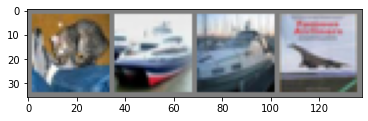

GroundTruth:    cat  ship  ship plane


In [40]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [41]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird   car  frog   dog


In [42]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda() # Send input images to gpu if available.

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


Compared to the 52% accuracy in the default tutorial, fine tuning a few of the parameters has significantly increased the accuracy. 

In [43]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda() # Send input images to gpu if available.
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 75 %
Accuracy of  bird : 48 %
Accuracy of   cat : 44 %
Accuracy of  deer : 53 %
Accuracy of   dog : 43 %
Accuracy of  frog : 73 %
Accuracy of horse : 63 %
Accuracy of  ship : 75 %
Accuracy of truck : 67 %
